In [1]:
import numpy as np

In [9]:
from numba import njit, jit

@njit(fastmath=True)
def get_n(n, x, y, color, img_no_dither, X, Y):
    valid_vector8n = np.zeros(8 * n)
    positive_count = 0
    total_count = 0
    nbrs_x = np.zeros(8 * n)
    nbrs_y = np.zeros(8 * n)

    nbrs_y[0] = y
    d = 1
    for k in range(1, 1 + n):
       nbrs_y[k] = y - d
       d = d + 1
    
    nbrs_y[1 + n:3 * n + 1] = y - n
    
    d = 0
    for k in range(3 * n + 1, 5 * n + 1):
       nbrs_y[k] = y - n + d
       d = d + 1
    
    nbrs_y[5 * n + 1:7 * n + 1] = y + n
    
    d = 0
    for k in range(7 * n + 1, 7 * n + 1 + (n - 1)):
       nbrs_y[k] = y + n - d
       d = d + 1
    
    nbrs_x[0] = x - n
    
    nbrs_x[1:1 + n] = x - n
    
    d = 0
    for k in range(1 + n, 3 * n + 1):
        nbrs_x[k] = x - n + d
        d = d + 1
    
    nbrs_x[3 * n + 1:5 * n + 1] = x + n
    
    d = 0
    for k in range(5 * n + 1, 7 * n + 1):
        nbrs_x[k] = x + n - d
        d = d + 1
        
    nbrs_x[7 * n + 1:7 * n + 1 + (n - 1)] = x - n
    
    for i in range(8 * n):
        
        if nbrs_x[i] > 0 and nbrs_x[i] <= X and nbrs_y[i] > 0 and nbrs_y[i] <= Y:
            valid_vector8n[i] = 1
        
        else:
            valid_vector8n[i] = 0
    for j in range(8 * n):
       if valid_vector8n[j] == 1:
          data = img_no_dither[int(nbrs_y[j]) - 1][int(nbrs_x[j]) - 1]
          if (data == color).all():
              positive_count = positive_count + 1
          total_count = total_count + 1
    return positive_count, total_count

In [41]:
import cv2

@jit(forceobj=True)
def fastmath_loops(img, distance_vector):
    correlogram_vector = []
    Y, X = img.shape[:2]
    d = len(distance_vector)
    count_matrix = np.zeros((256, d))
    total_matrix = np.zeros((256, d))
    prob_dist = np.zeros((256, d))
    for serial_no in range(d):
        for x in range(X):
            for y in range(Y):
                color = img[y, x]
                # At the given distance
                positive_count, total_count = get_n(distance_vector[serial_no], x, y, color, img, X, Y)
                count_matrix[color, serial_no] += positive_count
                total_matrix[color, serial_no] += total_count
        prob_dist[:, serial_no] = count_matrix[:, serial_no] / (1 + total_matrix[:, serial_no])
    print(len(correlogram_vector))
    for serial_no in range(d):
        correlogram_vector = np.concatenate((correlogram_vector, prob_dist[:, serial_no]))
    return correlogram_vector

def color_auto_correlogram(I, distance_vector = [1, 3]):
    # quantize image into 64 colors = 4x4x4, in RGB space
    img_no_dither = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    return fastmath_loops(img_no_dither, distance_vector)

In [13]:
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

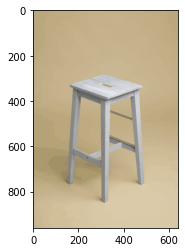

In [42]:
import matplotlib.pyplot as plt
image = cv2.imread("chair.jpg")
reduced_image = kmeans_color_quantization(image, clusters=64)

plt.imshow(reduced_image)

In [44]:
correlogram_vector = color_auto_correlogram(reduced_image, [1, 3])
print(correlogram_vector)

0
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.50359712 0.         0.         0.         0.50359712 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.50047197 0.         0.         0.
 0.         0.74467487 0.80807344 0.74467487 0.       

In [45]:
len(correlogram_vector)

512